### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar10 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 2

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [2]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [3]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

In [4]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    cumulative_forgetting = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[j]) / (j + 1) for j in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
        _, avg_forgetting = average_forgetting(task_accuracies)
        cumulative_forgetting.append(avg_forgetting)
    print(f"FAA: {np.mean(cumulative_averages, axis=0)[-1]:.2f} ± {np.std(cumulative_averages, axis=0)[-1]:.2f}")
    print(f"Avg. Forgetting: {np.mean(cumulative_forgetting, axis=0):.2f} ± {np.std(cumulative_forgetting, axis=0):.2f}")

    return np.round(np.mean(cumulative_averages, axis=0), decimals=2).tolist()

In [5]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [6]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(accuracy_arrays, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [99]:
def plot_cumulative_subplots(cumulative_averages, subtitles, labels, plot_filename=""):
    assert len(cumulative_averages) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    colors = [
        "#1f77b4",  # tab:blue
        "#d62728",  # tab:red
        "#ff7f0e",  # tab:orange
        "#2ca02c",  # tab:green
    ]

    fig, axes = plt.subplots(1, len(cumulative_averages) // 4, figsize=(20, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                "--o" if j == 0 else "-o",
                # label=f"{labels[j]}: {cumulative_averages[4 * i + j][-1]:.2f}%",
                label=f"{labels[j]}",
                color=colors[j],
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=16)
            axes[i].legend(prop={"size": 14}, loc="lower left")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 101, 10)))

    fig.supxlabel("Task Trained On", fontsize=16)
    fig.supylabel("Accuracy (%)\n", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

# ER

## Buffer 500

### Accuracy Without Drift

In [8]:
# er_500_accuracy_array_without_drift = read_results(
#     "./logs/01-23-25-03-17-48-seq-cifar10-er-buf-500-drift-6-n-2-adaptation-0.json"
# )
# # 33.97, 34.09, 34.25
# # 34.10333333333333 ± 0.11469767022723534
# # plot_results(
# #     er_500_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(er_500_accuracy_array_without_drift)[1]

In [9]:
er_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-03-17-48-seq-cifar10-er-buf-500-drift-6-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-03-17-48-seq-cifar10-er-buf-500-drift-6-n-2-adaptation-0.json
FAA: 34.09 ± 0.00
Avg. Forgetting: 75.29 ± 0.00


### Permutation Drift in Tasks 2, 4

In [10]:
# er_500_accuracy_array_with_drift = read_results(
#     "./logs/01-23-25-04-53-49-seq-cifar10-er-buf-500-drift-5-n-2-adaptation-0.json"
# )
# # 29.03, 29.16, 29.76
# # 29.316666666666666 ± 0.3179447890576116
# # plot_results(
# #     er_500_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 2, 4",
# # )
# average_forgetting(er_500_accuracy_array_with_drift)[1]

In [11]:
er_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-04-53-49-seq-cifar10-er-buf-500-drift-5-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-04-53-49-seq-cifar10-er-buf-500-drift-5-n-2-adaptation-0.json
FAA: 29.16 ± 0.00
Avg. Forgetting: 81.53 ± 0.00


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [12]:
# before reimplementation
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-06-21-58-seq-cifar10-er-buf-500-drift-5-n-2-adaptation-1.json"
# ) # 46.31, 47.64, 47.91
# # 47.28666666666667 ± 0.6993489035444941

In [13]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-15-46-05-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 46.30, 46.34, 48.01
# plot_results(
#     er_500_accuracy_array_with_drift_full_relearning,
#     title="ER with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=500)",
# )

In [14]:
er_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-15-46-05-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-15-02-41-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-14-20-44-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 46.88 ± 0.80
Avg. Forgetting: 58.06 ± 0.89


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [15]:
## before reimplementation
# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-07-27-40-seq-cifar10-er-buf-500-drift-5-n-2-adaptation-2.json"
# ) # 46.90, 47.75, 48.14
# # 47.59666666666667 ± 0.5177086267604811

In [16]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-16-14-05-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 48.41, 49.57, 49.77
# plot_results(
#     er_500_accuracy_array_with_drift_buffer_resampling,
#     title="ER with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=500)",
# )

In [17]:
er_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-16-14-05-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-19-25-16-42-54-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-17-11-44-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 49.25 ± 0.60
Avg. Forgetting: 55.78 ± 0.56


### Cumulative Plots

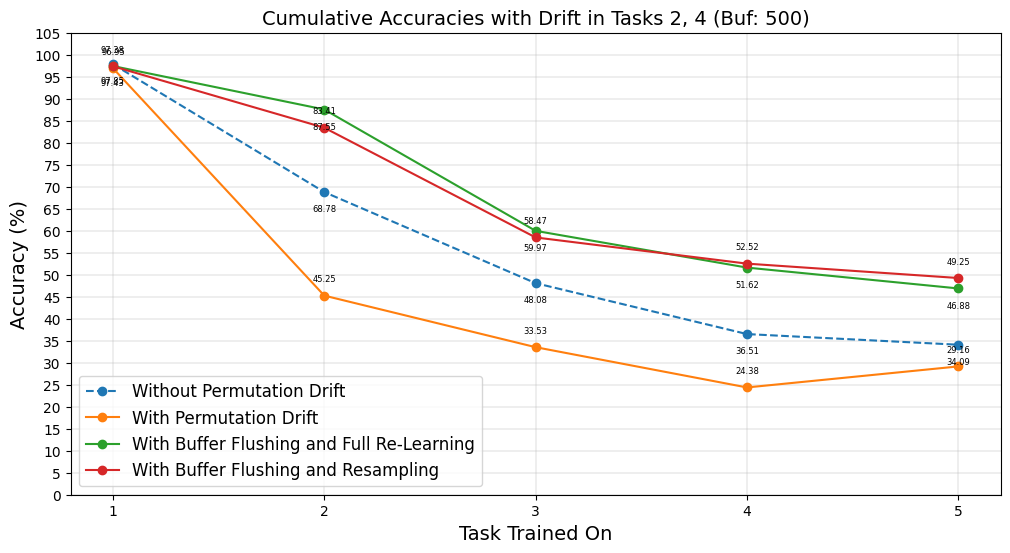

In [18]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [19]:
# er_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-23-25-08-51-55-seq-cifar10-er-buf-5000-drift-6-n-2-adaptation-0.json"
# )
# # 65.74, 65.78, 67.32
# # 66.27999999999999 ± 0.7355723395198214
# # plot_results(
# #     er_5000_accuracy_array_without_drift,
# #     title="ER Baseline CIL Accuracy",
# # )
# average_forgetting(er_5000_accuracy_array_without_drift)[1]

In [20]:
er_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-08-51-55-seq-cifar10-er-buf-5000-drift-6-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-08-51-55-seq-cifar10-er-buf-5000-drift-6-n-2-adaptation-0.json
FAA: 65.78 ± 0.00
Avg. Forgetting: 33.86 ± 0.00


### Permutation Drift in Tasks 2, 4

In [21]:
# er_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-23-25-11-13-13-seq-cifar10-er-buf-5000-drift-5-n-2-adaptation-0.json"
# )
# # 35.97, 36.09, 36.33
# # 36.13 ± 0.14966629547095697
# # plot_results(
# #     er_5000_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 2, 4",
# # )
# average_forgetting(er_5000_accuracy_array_with_drift)[1]

In [22]:
er_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-11-13-13-seq-cifar10-er-buf-5000-drift-5-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-11-13-13-seq-cifar10-er-buf-5000-drift-5-n-2-adaptation-0.json
FAA: 36.09 ± 0.00
Avg. Forgetting: 71.00 ± 0.00


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [23]:
## before reimplementation
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-13-28-15-seq-cifar10-er-buf-5000-drift-5-n-2-adaptation-1.json"
# ) # 64.39, 64.73, 66.26
# # 65.12666666666667 ± 0.8133196720164165

In [24]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-15-53-35-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 62.48, 63.46, 63.66
# plot_results(
#     er_5000_accuracy_array_with_drift_full_relearning,
#     title="ER with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=5000)",
# )

In [25]:
er_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-14-22-37-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-15-06-50-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-15-53-35-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 63.20 ± 0.52
Avg. Forgetting: 36.73 ± 0.59


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [26]:
## before reimplementation
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-14-51-31-seq-cifar10-er-buf-5000-drift-5-n-2-adaptation-2.json"
# ) # 64.39, 64.88, 65.05
# # 64.77333333333333 ± 0.2798015169524424

In [27]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-16-21-10-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 64.97, 65.06, 65.77
# plot_results(
#     er_5000_accuracy_array_with_drift_buffer_resampling,
#     title="ER with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=5000)",
# )

In [28]:
er_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-16-21-10-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-19-25-16-49-20-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-17-17-30-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 65.27 ± 0.36
Avg. Forgetting: 35.24 ± 0.46


### Cumulative Plots

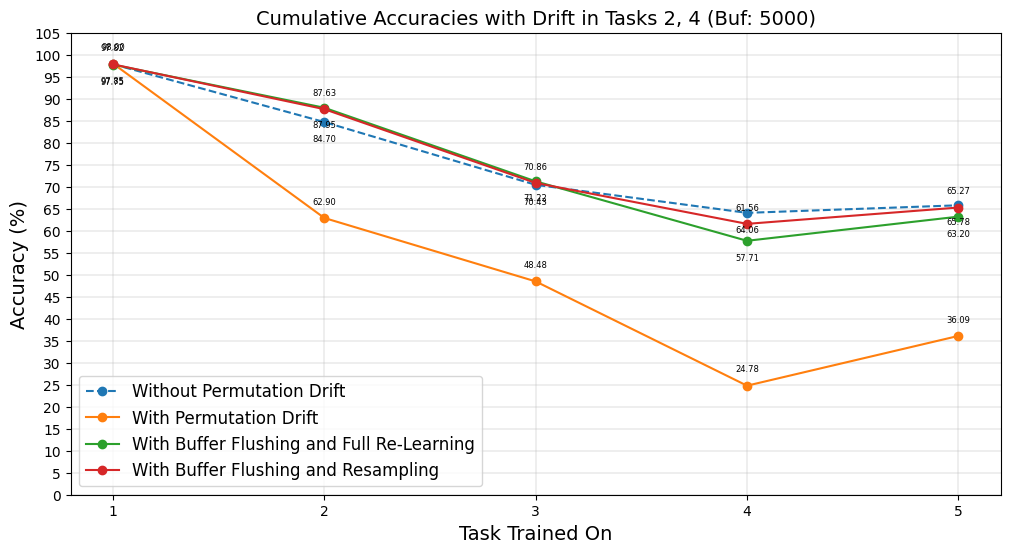

In [29]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Accuracy Without Drift

In [30]:
# er_ace_500_accuracy_array_without_drift = read_results(
#     "./logs/01-23-25-03-26-15-seq-cifar10-er_ace-buf-500-drift-6-n-2-adaptation-0.json"
# )
# # 55.81, 56.50, 57.32
# # 56.54333333333333 ± 0.6172159715655086
# # plot_results(
# #     er_ace_500_accuracy_array_without_drift,
# #     title="ER-ACE Baseline CIL Accuracy",
# # )
# average_forgetting(er_ace_500_accuracy_array_without_drift)[1]

In [31]:
er_ace_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-03-26-15-seq-cifar10-er_ace-buf-500-drift-6-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-03-26-15-seq-cifar10-er_ace-buf-500-drift-6-n-2-adaptation-0.json
FAA: 56.50 ± 0.00
Avg. Forgetting: 30.96 ± 0.00


### Permutation Drift in Tasks 2, 4

In [32]:
# er_ace_500_accuracy_array_with_drift = read_results(
#     "./logs/01-23-25-07-12-47-seq-cifar10-er_ace-buf-500-drift-5-n-2-adaptation-0.json"
# )
# # 29.70, 31.07, 31.51
# # 30.76 ± 0.7707572034477965
# # plot_results(
# #     er_ace_500_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 2, 4",
# # )
# average_forgetting(er_ace_500_accuracy_array_with_drift)[1]

In [33]:
er_ace_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-07-12-47-seq-cifar10-er_ace-buf-500-drift-5-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-07-12-47-seq-cifar10-er_ace-buf-500-drift-5-n-2-adaptation-0.json
FAA: 31.07 ± 0.00
Avg. Forgetting: 64.03 ± 0.00


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [34]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-08-37-10-seq-cifar10-er_ace-buf-500-drift-5-n-2-adaptation-1.json"
# )
# # 57.26, 58.55, 59.00
# # 58.27 ± 0.7374279625834654

In [35]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-16-10-28-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 52.50, 53.67, 55.52
# plot_results(
#     er_ace_500_accuracy_array_with_drift_full_relearning,
#     title="ER-ACE with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=500)",
# )

In [36]:
er_ace_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-14-53-39-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-17-23-38-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-16-10-28-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 53.90 ± 1.24
Avg. Forgetting: 37.75 ± 2.13


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [37]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-12-18-04-seq-cifar10-er_ace-buf-500-drift-5-n-2-adaptation-2.json"
# )
# # 49.05, 51.85, 52.26
# # 51.053333333333335 ± 1.4264252132126982

In [38]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-18-57-02-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 50.33, 50.72, 50.81
# plot_results(
#     er_ace_500_accuracy_array_with_drift_buffer_resampling,
#     title="ER-ACE with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=500)",
# )

In [39]:
er_ace_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-18-11-33-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-19-25-18-57-02-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-19-43-26-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 50.62 ± 0.21
Avg. Forgetting: 44.63 ± 0.55


### Cumulative Plots

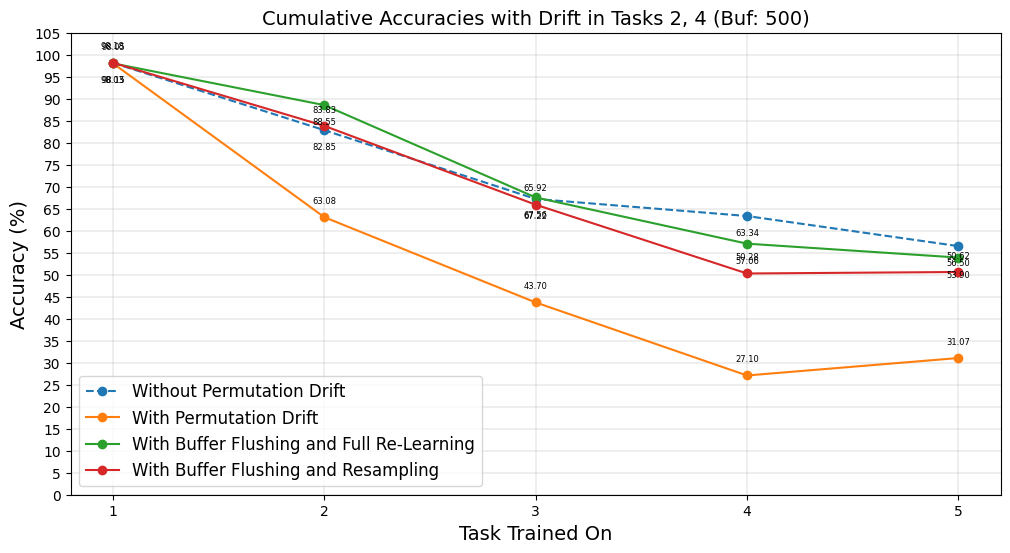

In [40]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [41]:
# er_ace_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-23-25-16-08-45-seq-cifar10-er_ace-buf-5000-drift-6-n-2-adaptation-0.json"
# )
# # 68.05, 68.81, 69.70
# # 68.85333333333334 ± 0.6743062278289382
# # plot_results(
# #     er_ace_5000_accuracy_array_without_drift,
# #     title="ER-ACE Baseline CIL Accuracy",
# # )
# average_forgetting(er_ace_5000_accuracy_array_without_drift)[1]

In [42]:
er_ace_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-16-08-45-seq-cifar10-er_ace-buf-5000-drift-6-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-16-08-45-seq-cifar10-er_ace-buf-5000-drift-6-n-2-adaptation-0.json
FAA: 68.81 ± 0.00
Avg. Forgetting: 16.55 ± 0.00


### Permutation Drift in Tasks 2, 4

In [43]:
# er_ace_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-23-25-18-13-47-seq-cifar10-er_ace-buf-5000-drift-5-n-2-adaptation-0.json"
# )
# # 31.87, 32.31, 32.92
# # 32.36666666666667 ± 0.4305293898859354
# # plot_results(
# #     er_ace_5000_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 2, 4",
# # )
# average_forgetting(er_ace_5000_accuracy_array_with_drift)[1]

In [44]:
er_ace_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-18-13-47-seq-cifar10-er_ace-buf-5000-drift-5-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-18-13-47-seq-cifar10-er_ace-buf-5000-drift-5-n-2-adaptation-0.json
FAA: 32.31 ± 0.00
Avg. Forgetting: 59.81 ± 0.00


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [45]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-20-32-36-seq-cifar10-er_ace-buf-5000-drift-5-n-2-adaptation-1.json"
# )
# # 65.54, 65.70, 66.35
# # 65.86333333333333 ± 0.3502697373295121

In [46]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-17-14-57-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 60.28, 61.61, 62.04
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_full_relearning,
#     title="ER-ACE with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=5000)",
# )

In [47]:
er_ace_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-14-51-11-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-16-03-18-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-17-14-57-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 61.31 ± 0.75
Avg. Forgetting: 27.70 ± 0.26


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [48]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-19-16-46-seq-cifar10-er_ace-buf-5000-drift-5-n-2-adaptation-2.json"
# ) # 64.35, 64.45, 64.82
# # 64.54 ± 0.20

In [49]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-19-34-53-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 64.63, 65.53, 65.65
# plot_results(
#     er_ace_5000_accuracy_array_with_drift_buffer_resampling,
#     title="ER-ACE with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=5000)",
# )

In [50]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-19-34-53-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-19-25-18-01-49-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-18-49-06-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 65.27 ± 0.46
Avg. Forgetting: 28.43 ± 0.39


### Cumulative Plots

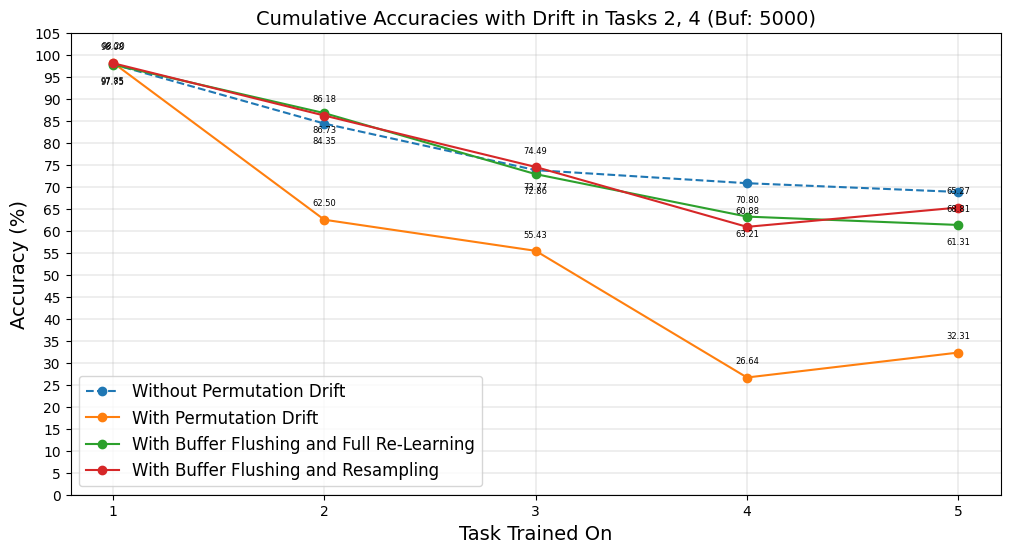

In [51]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# DER++

## Buffer 500

### Accuracy Without Drift

In [52]:
# derpp_500_accuracy_array_without_drift = read_results(
#     "./logs/01-23-25-04-51-27-seq-cifar10-derpp-buf-500-drift-6-n-2-adaptation-0.json"
# )
# # 39.43, 39.94, 43.46
# # 40.943333333333335 ± 1.791690697513262
# # plot_results(
# #     derpp_500_accuracy_array_without_drift,
# #     title="DER++ Baseline CIL Accuracy",
# # )
# average_forgetting(derpp_500_accuracy_array_without_drift)[1]

In [53]:
derpp_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-04-51-27-seq-cifar10-derpp-buf-500-drift-6-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-04-51-27-seq-cifar10-derpp-buf-500-drift-6-n-2-adaptation-0.json
FAA: 39.94 ± 0.00
Avg. Forgetting: 65.71 ± 0.00


### Permutation Drift in Tasks 2, 4

In [54]:
# derpp_500_accuracy_array_with_drift = read_results(
#     "./logs/01-23-25-07-47-44-seq-cifar10-derpp-buf-500-drift-5-n-2-adaptation-0.json"
# )
# # 29.58, 29.86, 30.78
# # 30.073333333333334 ± 0.5125968743130968
# # plot_results(
# #     derpp_500_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 2, 4",
# # )
# average_forgetting(derpp_500_accuracy_array_with_drift)[1]

In [55]:
derpp_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-07-47-44-seq-cifar10-derpp-buf-500-drift-5-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-07-47-44-seq-cifar10-derpp-buf-500-drift-5-n-2-adaptation-0.json
FAA: 29.86 ± 0.00
Avg. Forgetting: 78.15 ± 0.00


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [56]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-07-37-31-seq-cifar10-derpp-buf-500-drift-5-n-2-adaptation-1.json"
# ) # 52.31, 52.48, 52.71
# # 52.5 ± 0.16391054470858957

In [57]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-15-45-24-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 48.54, 50.31, 52.23
# plot_results(
#     derpp_500_accuracy_array_with_drift_full_relearning,
#     title="DER++ with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=500)",
# )

In [58]:
derpp_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-15-45-24-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-19-58-47-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-17-49-59-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 50.36 ± 1.51
Avg. Forgetting: 51.62 ± 1.49


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [59]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-10-34-39-seq-cifar10-derpp-buf-500-drift-5-n-2-adaptation-2.json"
# )
# # 51.94, 54.18, 55.43
# # 53.85 ± 1.4437682177782794

In [60]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-22-37-45-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 55.07, 55.21, 55.79
# plot_results(
#     derpp_500_accuracy_array_with_drift_buffer_resampling,
#     title="DER++ with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=500)",
# )

In [61]:
derpp_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-21-18-03-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-19-25-23-57-09-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-22-37-45-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 55.36 ± 0.31
Avg. Forgetting: 46.55 ± 0.13


### Cumulative Plots

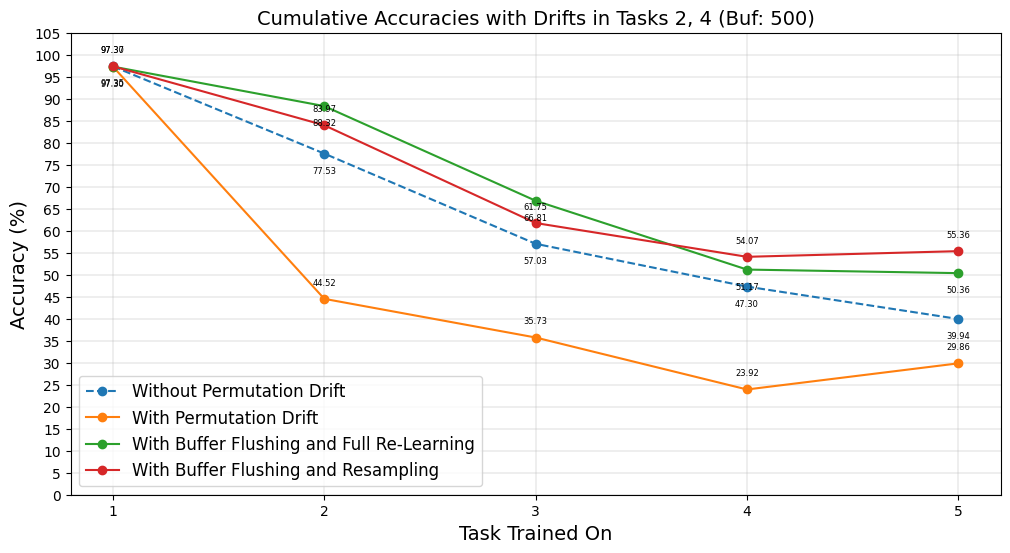

In [62]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Tasks 2, 4 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [63]:
# derpp_5000_accuracy_array_without_drift = read_results(
#     "./logs/01-23-25-04-53-49-seq-cifar10-derpp-buf-5000-drift-6-n-2-adaptation-0.json"
# )
# # 65.01, 65.31, 66.03
# # 65.45 ± 0.42801869118065244
# # plot_results(
# #     derpp_5000_accuracy_array_without_drift,
# #     title="DER++ Baseline CIL Accuracy",
# # )
# average_forgetting(derpp_5000_accuracy_array_without_drift)[1]

In [64]:
derpp_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-04-53-49-seq-cifar10-derpp-buf-5000-drift-6-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-04-53-49-seq-cifar10-derpp-buf-5000-drift-6-n-2-adaptation-0.json
FAA: 65.31 ± 0.00
Avg. Forgetting: 30.34 ± 0.00


### Permutation Drift in Tasks 2, 4

In [65]:
# derpp_5000_accuracy_array_with_drift = read_results(
#     "./logs/01-23-25-08-46-36-seq-cifar10-derpp-buf-5000-drift-5-n-2-adaptation-0.json"
# )
# # 35.07, 35.10, 35.57
# # 35.24666666666667 ± 0.22895899681432505
# # plot_results(
# #     derpp_5000_accuracy_array_with_drift,
# #     title="Accuracy with Permutation Drift in Tasks 2, 4",
# # )
# average_forgetting(derpp_5000_accuracy_array_with_drift)[1]

In [66]:
derpp_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./logs/01-23-25-08-46-36-seq-cifar10-derpp-buf-5000-drift-5-n-2-adaptation-0.json"
)

1 files found
1: ./logs/01-23-25-08-46-36-seq-cifar10-derpp-buf-5000-drift-5-n-2-adaptation-0.json
FAA: 35.10 ± 0.00
Avg. Forgetting: 67.99 ± 0.00


### Permutation Drift in Tasks 2, 4 with Adaptive Re-Learning

In [67]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-04-32-39-seq-cifar10-derpp-buf-5000-drift-5-n-2-adaptation-1.json"
# ) # 64.59, 65.39, 66.49
# # 65.49000000000001 ± 0.778888096369858

In [68]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./reimplementation-logs/02-19-25-15-45-46-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
# )
# # 63.17, 64.14, 65.05
# plot_results(
#     derpp_5000_accuracy_array_with_drift_full_relearning,
#     title="DER++ with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=5000)",
# )

In [69]:
derpp_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-17-51-03-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-15-45-46-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-20-01-25-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 64.12 ± 0.77
Avg. Forgetting: 31.77 ± 0.81


### Permutation Drift in Tasks 2, 4 with Adaptive Buffer Resampling

In [70]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-08-38-41-seq-cifar10-derpp-buf-5000-drift-5-n-2-adaptation-2.json"
# )
# # 65.09, 65.12, 66.95
# # 65.72000000000001 ± 0.8698275691193049

In [71]:
# cumulative_average_multiple_runs(
#     "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./reimplementation-logs/02-19-25-21-21-29-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
# )
# # 63.36, 64.67, 64.69
# plot_results(
#     derpp_5000_accuracy_array_with_drift_buffer_resampling,
#     title="DER++ with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=5000)",
# )

In [72]:
derpp_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/02-19-25-21-21-29-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-20-25-00-01-41-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-22-41-56-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 64.24 ± 0.62
Avg. Forgetting: 35.23 ± 0.34


### Cumulative Plots

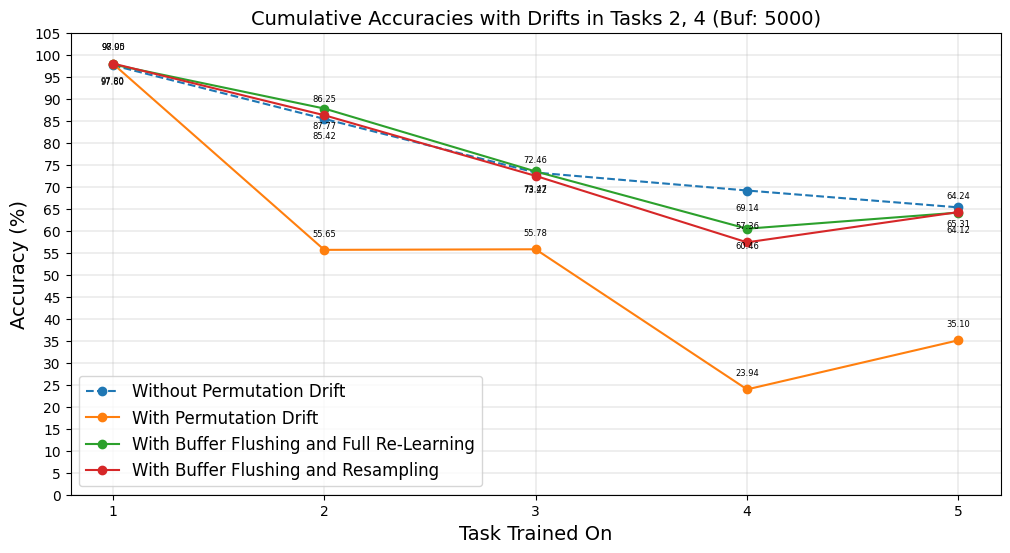

In [73]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Tasks 2, 4 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# SER

## Buffer 500

### Accuracy Without Drift

In [74]:
ser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-01-11-58-seq-cifar10-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/03-27-25-00-37-16-seq-cifar10-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/03-27-25-00-02-12-seq-cifar10-ser-buf-500-drift-6-s-5-n-2-adaptation-0.json
FAA: 57.08 ± 0.41
Avg. Forgetting: 31.91 ± 0.73


### Permutation Drift in Tasks 2, 4

In [75]:
ser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-02-57-18-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/03-27-25-02-22-13-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/03-27-25-01-46-35-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 32.54 ± 0.70
Avg. Forgetting: 63.96 ± 1.29


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [76]:
ser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-04-00-09-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/03-27-25-06-16-05-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/03-27-25-05-08-07-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 59.60 ± 0.69
Avg. Forgetting: 23.66 ± 0.43


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [77]:
ser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-07-28-35-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/03-27-25-08-04-39-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/03-27-25-06-52-30-seq-cifar10-ser-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 48.68 ± 1.45
Avg. Forgetting: 51.50 ± 1.90


### Cumulative Plots

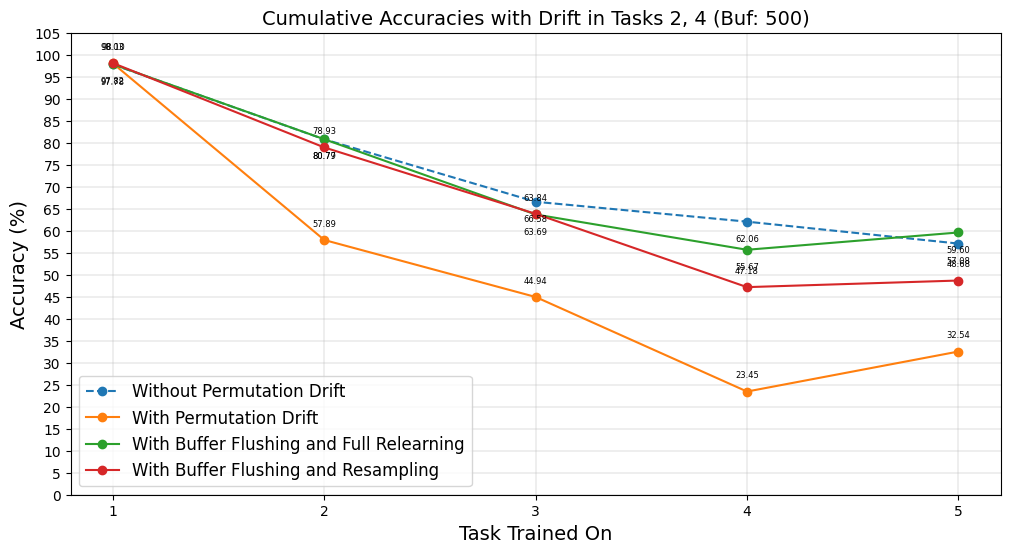

In [78]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 500)",
    [
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [79]:
ser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-09-52-07-seq-cifar10-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/03-27-25-09-16-27-seq-cifar10-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/03-27-25-08-40-23-seq-cifar10-ser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
FAA: 69.05 ± 0.51
Avg. Forgetting: 14.62 ± 0.58


### Permutation Drift in Tasks 2, 4

In [80]:
ser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-11-04-00-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/03-27-25-10-28-06-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/03-27-25-11-40-02-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
FAA: 33.95 ± 0.40
Avg. Forgetting: 58.70 ± 1.12


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [81]:
ser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-12-39-21-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/03-27-25-14-38-05-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/03-27-25-13-40-16-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 63.54 ± 0.38
Avg. Forgetting: 23.94 ± 1.23


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [82]:
ser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-15-14-28-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/03-27-25-16-15-55-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/03-27-25-15-45-26-seq-cifar10-ser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 59.05 ± 0.68
Avg. Forgetting: 39.98 ± 1.35


### Cumulative Plots

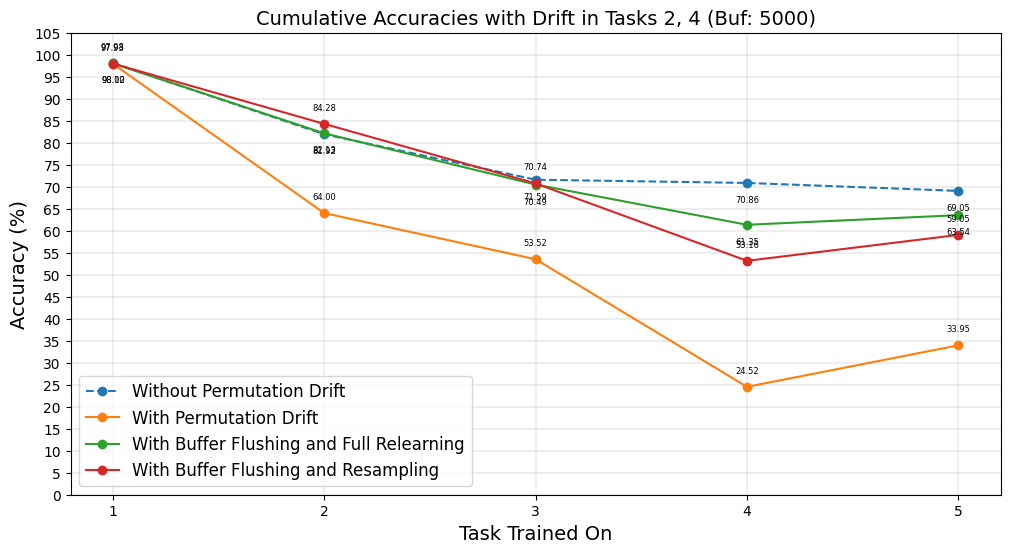

In [83]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 5000)",
    [
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# CLSER

## Buffer 500

### Accuracy Without Drift

In [84]:
clser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-01-01-33-seq-cifar10-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/03-27-25-01-41-14-seq-cifar10-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/03-27-25-00-21-24-seq-cifar10-clser-buf-500-drift-6-s-5-n-2-adaptation-0.json
FAA: 29.41 ± 0.76
Avg. Forgetting: 80.80 ± 1.00


### Permutation Drift in Tasks 2, 4

In [85]:
clser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-02-20-44-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/03-27-25-03-01-16-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/03-27-25-03-41-40-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-0.json
FAA: 26.20 ± 0.42
Avg. Forgetting: 84.63 ± 0.87


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [86]:
clser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-05-49-48-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/03-27-25-07-16-12-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/03-27-25-04-45-34-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 46.48 ± 0.75
Avg. Forgetting: 58.90 ± 1.09


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [87]:
clser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-08-08-42-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/03-27-25-08-49-18-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/03-27-25-09-29-45-seq-cifar10-clser-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 53.41 ± 0.84
Avg. Forgetting: 50.61 ± 1.00


### Cumulative Plots

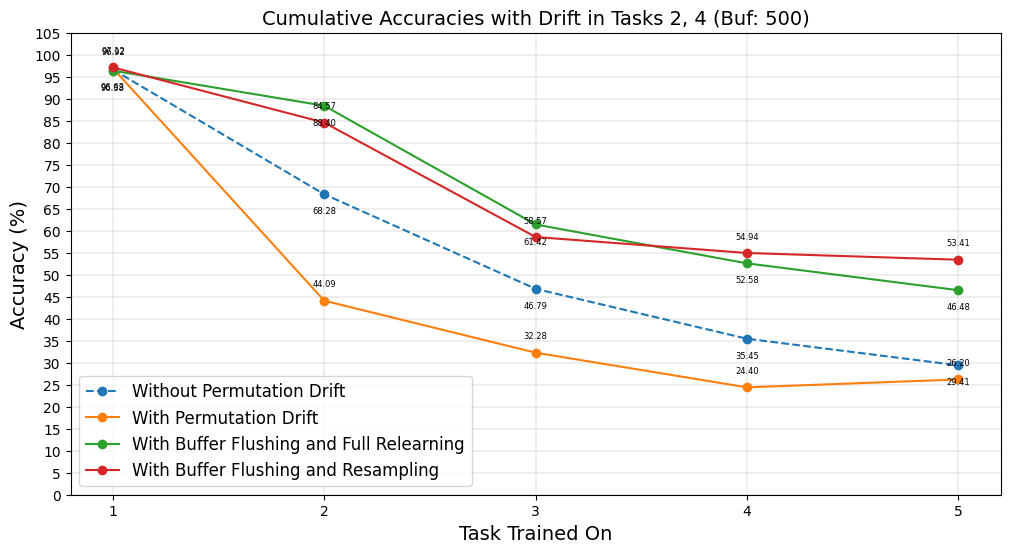

In [88]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 500)",
    [
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [89]:
clser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-10-52-18-seq-cifar10-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/03-27-25-10-10-59-seq-cifar10-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/03-27-25-11-33-39-seq-cifar10-clser-buf-5000-drift-6-s-5-n-2-adaptation-0.json
FAA: 67.22 ± 0.75
Avg. Forgetting: 32.70 ± 0.82


### Permutation Drift in Tasks 2, 4

In [90]:
clser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-12-55-27-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
2: ./reimplementation-logs/03-27-25-12-14-43-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
3: ./reimplementation-logs/03-27-25-13-35-08-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-0.json
FAA: 36.31 ± 0.23
Avg. Forgetting: 71.57 ± 0.46


### Permutation Drift in Tasks 2, 4 with Full Relearning

In [91]:
clser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-15-44-35-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/03-27-25-14-39-07-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/03-27-25-16-50-10-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 64.59 ± 0.30
Avg. Forgetting: 34.99 ± 0.36


### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [92]:
clser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/03-27-25-18-12-43-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/03-27-25-18-43-53-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/03-27-25-17-32-20-seq-cifar10-clser-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 67.58 ± 0.40
Avg. Forgetting: 32.15 ± 0.38


### Cumulative Plots

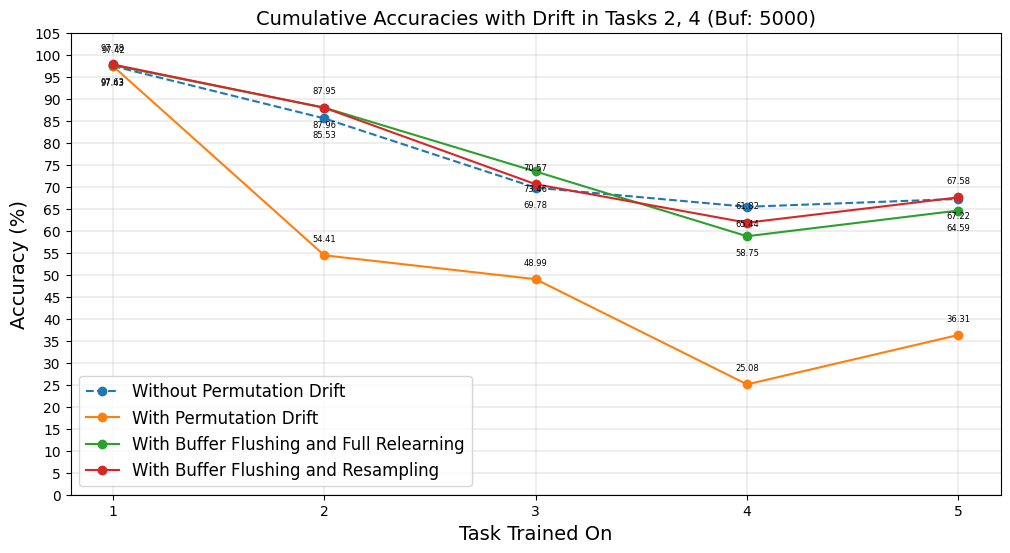

In [93]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 5000)",
    [
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

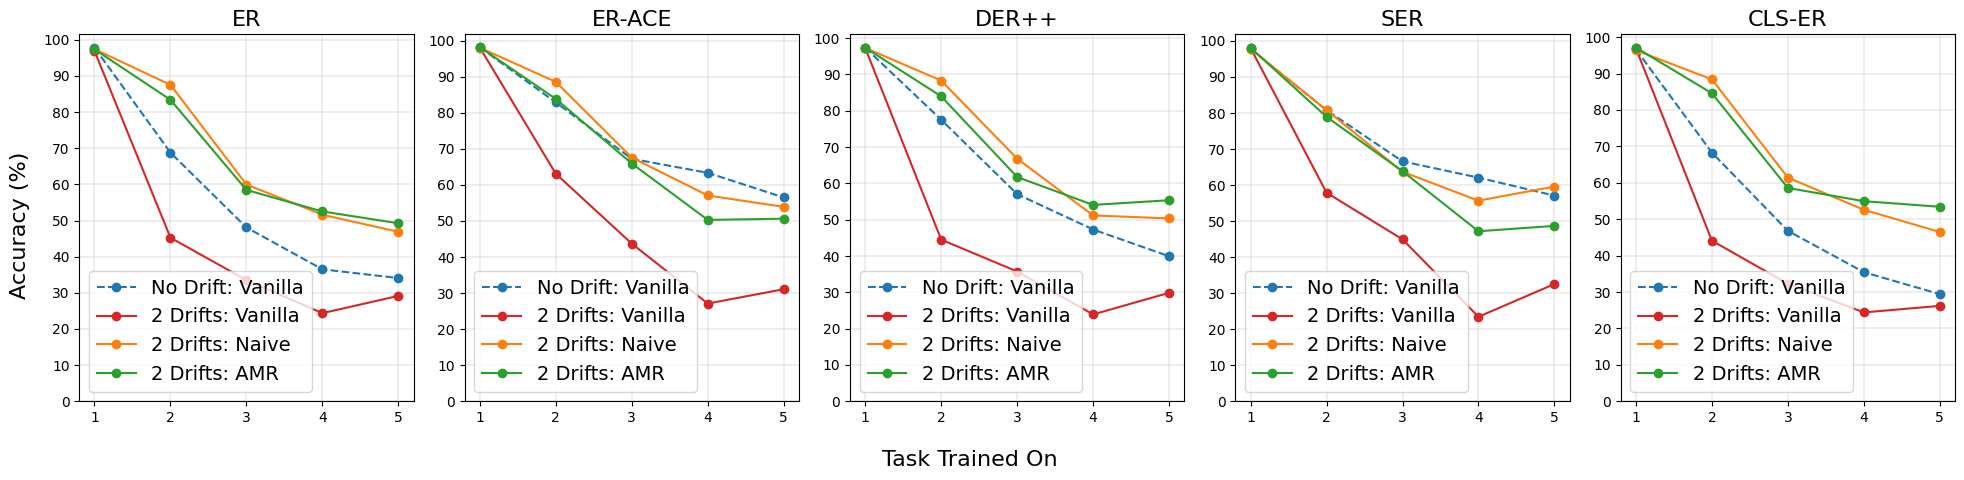

In [100]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "2 Drifts: Vanilla",
        "2 Drifts: Naive",
        "2 Drifts: AMR",
    ],
    plot_filename="CIFAR10_Buff_500_n_2.pdf",
)

## Buffer 5000

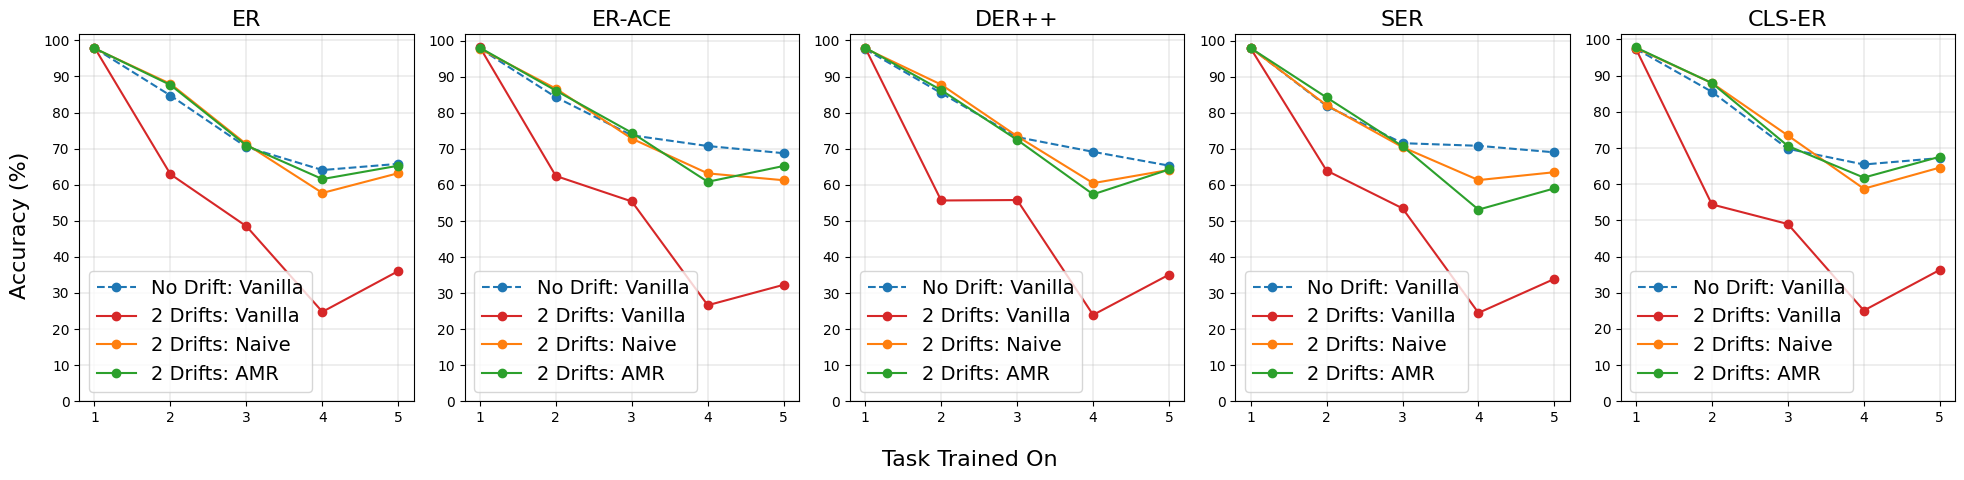

In [101]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "2 Drifts: Vanilla",
        "2 Drifts: Naive",
        "2 Drifts: AMR",
    ],
    plot_filename="CIFAR10_Buff_5000_n_2.pdf",
)